In [1]:
from sklearn import model_selection , linear_model, metrics, pipeline,tree, preprocessing,neighbors,ensemble,svm,naive_bayes
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split,RandomizedSearchCV,cross_val_predict
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE,RFECV

#from sklearn import model_selection import grid_search
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from itertools import *
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
original_train_data = pd.read_csv('./data/train.csv')
original_test_data = pd.read_csv('./data/test.csv')

In [3]:
def prepare_data(data,mode): 
    
    #Обработка пропусков
    #Заполняем медианой
    #raw_data.Age = raw_data.Age.fillna(raw_data.Age.median())
    #Заполняем медианой c группировкой
    raw_data=data.copy()
    grp = raw_data.groupby(['Sex', 'Pclass'])  
    raw_data.Age = grp.Age.apply(lambda x: x.fillna(x.median()))
    #Заполняем модой
    #raw_data.Embarked = raw_data.Embarked.fillna(raw_data.Embarked.value_counts().idxmax())
    raw_data.Embarked.fillna(raw_data.Embarked.mode()[0], inplace = True)
    raw_data.Fare.fillna(raw_data.Fare.mode()[0],inplace = True)
    #Заполняем 'N'
    raw_data.Cabin = raw_data.Cabin.fillna('NA')

    
    if mode=='new_features':
        print('--new_features mode--')
        #raw_data.Embarked.value_counts()
        #добавим новые признаки
        raw_data['Family'] = raw_data.Parch + raw_data.SibSp+1
        raw_data['Family_Size'] = pd.cut(raw_data.Family, [0,1.5,4.5,15],labels=['Single','SmallFamily','LargeFamily'])
        #raw_data['Is_Alone'] = (raw_data.Family == 0).astype(int)
        raw_data['Salutation'] = raw_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
        raw_data['Age_Range'] = pd.cut(raw_data.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
        raw_data['Fare_Category'] = pd.cut(raw_data.Fare, bins=[0,7.90,14.45,31.28,120.0,513.0],include_lowest = True, labels=['Low','Mid','High_Mid','High','Upper_High'])
        raw_data['isCabin']=raw_data.Cabin.apply(lambda x: 1 if x != 'NA' else 0)
        np.seterr(divide = 'ignore')
        raw_data['Log_Fare']=np.log10(raw_data.Fare).replace(-np.inf, 0)
        #raw_train_data.iloc[np.where(raw_train_data.Log_Fare.values<np.finfo(np.float64).min)]
        #raw_data['Fare_Category'] = pd.cut(raw_data['Fare'], bins=[0,7.90,14.45,31.28,120.0], labels=['Low','Mid','High_Mid','High'])
        #raw_data['Fare_Category'] = pd.cut(raw_data['Fare'], [0,7.90,14.45,31.28,120.0,513.0],include_lowest = True)
        #raw_data.Salutation.nunique()
        #####################New features#####################
        name_dict = {"Capt":       "officer",
                     "Col":        "officer",
                     "Major":      "officer",
                     "Dr":         "officer",
                     "Rev":        "officer",
                     "Jonkheer":   "snob",
                     "Don":        "snob",
                     "Sir" :       "snob",
                     "the Countess":"snob",
                     "Dona":       "snob",
                     "Lady" :      "snob",
                     "Mme":        "married",
                     "Ms":         "married",
                     "Mrs" :       "married",
                     "Miss" :      "single",
                     "Mlle":       "single",
                     "Mr" :        "man",
                     "Master" :    "boy"
                    }
        raw_data['Salutation_type'] = raw_data['Salutation'].map(name_dict)
        
    else:
        print('--Original mode--')
        pass
        
    return raw_data


In [4]:
def create_estimator(numeric_data_indices,categorical_data_indices,classifier):
    estimator = pipeline.Pipeline(steps = [       
        (
            'feature_processing', pipeline.FeatureUnion(transformer_list = [        
                #binary
                #('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                        
                #numeric
                ('numeric_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices],validate=False)),
                    ('scaling', preprocessing.StandardScaler())            
                            ])),
        
                #categorical
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices],validate=False)),
                    ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse=False))            
                            ])),
            ])
        ),
        ('model_fitting', classifier)
        ]
    )
    return estimator

## Train data

In [5]:
#Подготовка с отбором признаков

#exclude_col = ['Name', 'Embarked', 'Cabin', 'isCabin','Salutation', 'Sex', 'Family']
#['Name', 'Embarked', 'Cabin', 'isCabin'] ['Salutation', 'Sex', 'Family']
#prepare_data(raw_train_data,[])



train_data=prepare_data(original_train_data,'new_features')

train_labels = train_data['Survived']
train_data.drop(['PassengerId', 'Survived'], axis = 1,inplace=True)
all_column=train_data.columns
#Описание колонок и индексов для FeatureUnion
string_data_columns = ['Name','Ticket','Cabin']
categorical_data_columns = ['Pclass','Sex','Embarked','Salutation','Age_Range', 'Fare_Category','Family_Size','Salutation_type']
numeric_data_columns = ['Age', 'SibSp', 'Parch', 'Fare','Family','isCabin','Log_Fare']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)


--new_features mode--


In [6]:
#train_data.head()

In [7]:
#train_data.loc[:,categorical_data_indices]

In [8]:
numeric_data_indices,categorical_data_indices

(array([False, False, False,  True,  True,  True, False,  True, False,
        False,  True, False, False, False, False,  True,  True, False]),
 array([ True, False,  True, False, False, False, False, False, False,
         True, False,  True,  True,  True,  True, False, False,  True]))

## Отбор признаков

### Wrapper methods(Включение исключения)

In [9]:
clf = svm.SVC(kernel="linear")

In [10]:
#def create_estimator(numeric_data_indices,categorical_data_indices,classifier):

estimator = pipeline.Pipeline(steps = [       
        (
            'feature_processing', pipeline.FeatureUnion(transformer_list = [        
                #binary
                #('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                        
                #numeric
                ('numeric_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices],validate=False)),
                    ('scaling', preprocessing.StandardScaler())            
                            ])),
        
                #categorical
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices],validate=False)),
                    ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse=False))            
                            ])),
            ])
        ),
        #('rfecv', RFECV(estimator=clf, scoring='accuracy')) #RFE
        ('rfe', RFE(estimator=clf, ))
        
        ]
    )
#    return estimator

In [11]:
estimator.fit(train_data.values, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric_variables_processing',
                                                 Pipeline(memory=None,
                                                          steps=[('selecting',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x00000000135FA6A8>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
         

In [109]:
#all_column=numeric_data_columns+list(grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[1][1].get_feature_names())
#coef=grid_cv.best_estimator_.steps[1][1].coef_[0]
#sorted(zip(np.abs(coef),all_column),reverse=True)

In [110]:
all_column=numeric_data_columns+list(estimator.named_steps['feature_processing'].transformer_list[1][1].named_steps['hot_encoding'].get_feature_names())
coef=list(estimator.named_steps['rfe'].estimator_.coef_[0])
coef_list=sorted(zip(np.abs(coef),all_column),reverse=True)
estimator.named_steps['rfe'].ranking_
rank=list(estimator.named_steps['rfe'].ranking_)
rank_list = sorted(zip(rank,all_column))
support=list(estimator.named_steps['rfe'].support_)
support_list = sorted(zip(support,all_column))
RFE_list=list(zip(all_column,coef,rank,support))

In [116]:
RFE_df=pd.DataFrame({'F_name':all_column,'rank':rank,'support':support})
RFE_df.sort_values(by=['rank'],ascending=True).head()

,F_name,rank,support
26,x4_Miss,1,True
52,x7_single,1,True
25,x4_Master,1,True
32,x4_Rev,1,True
33,x4_Sir,1,True


In [117]:
print('Num Features: %d',estimator.named_steps['rfe'].n_features_)
print('Selected Features:', estimator.named_steps['rfe'].support_)
print('Feature Ranking:', estimator.named_steps['rfe'].ranking_)
print('Feature Coef:', estimator.named_steps['rfe'].estimator_.coef_)

Num Features: %d 27
Selected Features: [False  True False  True False False  True False False False  True  True
 False False False  True  True  True  True False  True  True  True False
 False  True  True False False  True  True False  True  True False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True False]
Feature Ranking: [ 4  1 17  1  9 13  1 10 15 14  1  1 11 16 20  1  1  1  1 24  1  1  1 28
 26  1  1 27 25  1  1 23  1  1 22  5  7  8 21 18 19  2  3  6  1  1  1  1
  1  1  1  1  1 12]
Feature Coef: [[-0.0165531   0.26662098 -0.02528948  0.84113996 -0.84113996 -1.33414634
   0.66163897  0.67250736 -0.2141769  -0.49773891 -0.0646577  -0.49011627
   0.77614164 -0.08101701 -0.2450644  -0.07784303 -0.10552742  1.
   0.1036299   0.16075959  0.15542689 -0.44329393  0.77614164 -0.2450644
  -0.07784303 -0.38436202 -0.08101701]]


### Recursive feature elimination with cross-validation

In [124]:
#def create_estimator(numeric_data_indices,categorical_data_indices,classifier):

estimator = pipeline.Pipeline(steps = [       
        (
            'feature_processing', pipeline.FeatureUnion(transformer_list = [        
                #binary
                #('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                        
                #numeric
                ('numeric_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices],validate=False)),
                    ('scaling', preprocessing.StandardScaler())            
                            ])),
        
                #categorical
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices],validate=False)),
                    ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore',sparse=False))            
                            ])),
            ])
        ),
        ('rfecv', RFECV(estimator=clf, step=1, cv=model_selection.StratifiedKFold(2),scoring='accuracy'))
        
        ]
    )
#    return estimator

In [125]:
estimator.fit(train_data.values, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric_variables_processing',
                                                 Pipeline(memory=None,
                                                          steps=[('selecting',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7feebcaf8a70>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
             

In [128]:
print('Num Features: ',estimator.named_steps['rfecv'].n_features_)
print('Selected Features:', estimator.named_steps['rfecv'].support_)
print('Feature Ranking:', estimator.named_steps['rfecv'].ranking_)
print('Feature Coef:', estimator.named_steps['rfecv'].estimator_.coef_)

Num Features:  10
Selected Features: [False False False False False False False False False False  True  True
 False False False  True  True  True False False False False  True False
 False  True False False False False False False False  True False False
 False False False False False False False False False False False False
  True False False  True False False]
Feature Ranking: [21 18 34 13 26 30 17 27 32 31  1  1 28 33 37  1  1  1  5 41  2  7  1 45
 43  1  9 44 42  4  8 40  6  1 39 22 24 25 38 35 36 19 20 23 16 14 15 12
  1  3 10  1 11 29]
Feature Coef: [[ 9.99903549e-01 -9.99903549e-01 -1.33333333e+00  6.66763117e-01
   6.66570216e-01 -1.92901235e-04  9.99614198e-01  1.00000000e+00
   9.99614198e-01  0.00000000e+00]]


In [131]:
estimator.named_steps['rfecv'].n_features_

10

Optimal number of features : 10


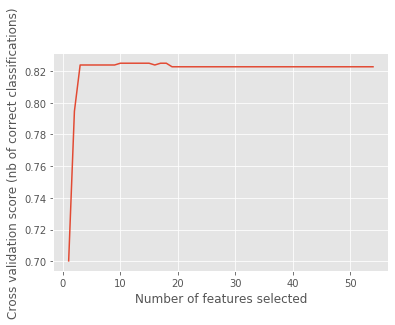

In [133]:
print('Optimal number of features :', estimator.named_steps['rfecv'].n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(estimator.named_steps['rfecv'].grid_scores_) + 1), estimator.named_steps['rfecv'].grid_scores_)
plt.show()

### Перебор подмножеств признаков n<=5

In [ ]:
#classifier_dict = {'RiC':linear_model.RidgeClassifier(),'SVC':svm.SVC(gamma='auto') ,'RF':ensemble.RandomForestClassifier(n_estimators=10),'GB':ensemble.GradientBoostingClassifier(),'KNC':neighbors.KNeighborsClassifier(),'DeTree':tree.DecisionTreeClassifier()}
classifier_dict = {'GB':ensemble.GradientBoostingClassifier()}

In [ ]:
#Сочетание без повторений
combinations_features_1=[[x] for x in all_column]
print('len combinations_features_1:',len(combinations_features_1))
combinations_features_2=[list(set().union(*x)) for x in combinations(combinations_features_1, 2)]
print('len combinations_features_2:',len(combinations_features_2))
combinations_features_3=[list(set().union(*x)) for x in combinations(combinations_features_1, 3)]
print('len combinations_features_3:',len(combinations_features_3))
combinations_features_4=[list(set().union(*x)) for x in combinations(combinations_features_1, 4)]
print('len combinations_features_4:',len(combinations_features_4))
#combinations_features_5=[list(set().union(*x)) for x in combinations(combinations_features_1, 5)]
#print('len combinations_features_5:',len(combinations_features_5))
combinations_features_all=[[]]+combinations_features_1+combinations_features_2+\
combinations_features_3+combinations_features_4#+combinations_features_5
print('len combinations_features_all:',len(combinations_features_all))

In [ ]:
%%time
# Перебор изъятия признаков


exclude_col_list=[]
clf_res_list=[]
#cv_res_list=[]
mean_res_list=[]
max_res_list=[]
min_res_list=[]
std_res_list=[]
#test_acc=[]
#for exclude_col in all_column:
for exclude_col in combinations_features_all:
    #exclude_col=list(set().union(*exclude_col_tup))
    #print(exclude_col)
    
    current_train_data=train_data.copy()
    current_train_data.drop(exclude_col, axis = 1,inplace=True)
    current_categorical_data_indices = np.array([(column in categorical_data_columns) for column in current_train_data.columns], dtype = bool)
    current_numeric_data_indices = np.array([(column in numeric_data_columns) for column in current_train_data.columns], dtype = bool)

    for k, v in classifier_dict.items():
        #print("Code : {0}, Value : {1}".format(k, v))
        #print('***Classifier*****',k)
        clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
        clf_scoring = cross_val_score(clf, current_train_data.values, train_labels, scoring = 'accuracy', cv = 3)
            #print ('mean:{}, max:{}, min:{}, std:{}'.format(clf_scoring.mean(), clf_scoring.max(), clf_scoring.min(), clf_scoring.std()))
        exclude_col_list.append(exclude_col)   
        clf_res_list.append(k)
        #cv_res_list.append(name)
        mean_res_list.append(clf_scoring.mean())
        max_res_list.append(clf_scoring.max())
        min_res_list.append(clf_scoring.min())
        std_res_list.append(clf_scoring.std())
        #clf.fit(X_train, y_train)
        #y_pred=clf.predict(X_test)
        #test_acc.append(accuracy_score(y_test, y_pred))
    

In [ ]:
select_f_df=pd.DataFrame({'ex_col':exclude_col_list,'clf':clf_res_list,'mean':mean_res_list,'max':max_res_list,'min':min_res_list,'std':std_res_list})
select_f_df.sort_values(by=['mean'],ascending=False)#.head(20)

In [ ]:
select_f_df.sort_values(by=['mean'],ascending=False)#.head(20)

In [ ]:
#select_f_df.to_csv('select_f_df_origin')
select_f_df.nlargest(10, 'mean')

In [ ]:
select_f_df_max_10_mean=select_f_df[select_f_df.clf=='GB'].nlargest(10, 'mean').copy()
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='KNC'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='DeTree'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='DeTree'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='RF'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='SVC'].nlargest(10, 'mean'))
select_f_df_max_10_mean=select_f_df_max_10_mean.append(select_f_df[select_f_df.clf=='RiC'].nlargest(10, 'mean'))

In [ ]:
select_f_df[select_f_df.clf=='SVC'].nlargest(10, 'mean')

In [ ]:
select_f_df_max_10_mean.groupby(['clf']).max()

In [ ]:
select_f_df_max_10_mean.sort_values(by=['mean'],ascending=False).head(20)

### Разделение выборки

In [ ]:
#Подготовка с отбором признаков
exclude_col=['Age', 'Family_Size', 'Salutation', 'Fare_Category']
#exclude_col = ['Name', 'Embarked', 'Cabin', 'isCabin','Salutation', 'Sex', 'Family']
#['Name', 'Embarked', 'Cabin', 'isCabin'] ['Salutation', 'Sex', 'Family']
#prepare_data(raw_train_data,[])

#current_train_data=original_train_data.copy()
#prepare_data(current_train_data,exclude_col)
#train_labels = raw_train_data['Survived']
#current_train_data = current_train_data.drop(['PassengerId', 'Survived'], axis = 1)
#print(current_train_data.columns)
#current_categorical_data_indices = np.array([(column in categorical_data_columns) for column in current_train_data.columns], dtype = bool)
#current_numeric_data_indices = np.array([(column in numeric_data_columns) for column in current_train_data.columns], dtype = bool)
#clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
#clf_scoring = cross_val_score(clf, current_train_data.values, train_labels, scoring = 'accuracy', cv = 3)

current_train_data=train_data.copy()
current_train_data.drop(exclude_col, axis = 1,inplace=True)
current_categorical_data_indices = np.array([(column in categorical_data_columns) for column in current_train_data.columns], dtype = bool)
current_numeric_data_indices = np.array([(column in numeric_data_columns) for column in current_train_data.columns], dtype = bool)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(current_train_data.values, train_labels, test_size=0.33,shuffle=True, random_state=42)
#stratify=train_labels
X_train.shape,X_test.shape,y_train.shape,y_test.shape

### Test

In [ ]:
test_data=prepare_data(original_test_data,'new_features')
#current_train_data=original_train_data.copy()
#prepare_data(current_train_data,'',exclude_col)
#train_labels = train_data['Survived']
test_data.drop(['PassengerId']+exclude_col, axis = 1,inplace=True)
all_column_test=test_data.columns
#Описание колонок и индексов для FeatureUnion
#Колонки
#Проверка пропусков
NAs = pd.concat([test_data.isnull().sum()], axis=1, keys=['data'])
print('Проверка пропусков',NAs[NAs.sum(axis=1) > 0])

### оценка алгоритмов

In [ ]:
# кросс валидация cтратегии
cv_strategy_SKF = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
cv_strategy_KF =model_selection.KFold(n_splits=5, shuffle = True, random_state = 0)
cv_strategy_ShS =model_selection.ShuffleSplit(n_splits=5, train_size=0.5, test_size=.25,random_state=0)
cv_strategy_ShS =model_selection.StratifiedShuffleSplit(n_splits=5, train_size=0.5, test_size=.25,random_state=0)
cv_dict = {'SKF':cv_strategy_SKF,'KF':cv_strategy_KF,'ShS':cv_strategy_ShS,'ShS':cv_strategy_ShS}

In [ ]:
classifier_dict = {'RiC':linear_model.RidgeClassifier(),'SVC':svm.SVC(gamma='auto'),'SGD':linear_model.SGDClassifier(),'LR':linear_model.LogisticRegression(solver='lbfgs'),
                   'KNC':neighbors.KNeighborsClassifier(),'DeTree':tree.DecisionTreeClassifier(),
                   'RF':ensemble.RandomForestClassifier(n_estimators=10),'GB':ensemble.GradientBoostingClassifier(),
                   'BG':ensemble.BaggingClassifier(),'NB':naive_bayes.GaussianNB()}

In [ ]:
%%time
# кросс валидация оценка

clf_res_list=[]
cv_res_list=[]
mean_res_list=[]
max_res_list=[]
min_res_list=[]
std_res_list=[]
test_acc=[]
for k, v in classifier_dict.items():
    #print("Code : {0}, Value : {1}".format(k, v))
    print('***Classifier*****',k)
    clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,v)
    for name,val in cv_dict.items():
        clf_scoring = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = val)
        print('--cv--',name,'----',val)
        #print ('mean:{}, max:{}, min:{}, std:{}'.format(clf_scoring.mean(), clf_scoring.max(), clf_scoring.min(), clf_scoring.std()))
        clf_res_list.append(k)
        cv_res_list.append(name)
        mean_res_list.append(clf_scoring.mean())
        max_res_list.append(clf_scoring.max())
        min_res_list.append(clf_scoring.min())
        std_res_list.append(clf_scoring.std())
        clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        test_acc.append(accuracy_score(y_test, y_pred))

In [ ]:
res_table=pd.DataFrame({'clf':clf_res_list, 'cv':cv_res_list,'mean':mean_res_list,'max':max_res_list,'min':min_res_list,'std':std_res_list,'test_acc':test_acc})
res_table.sort_values(by=['test_acc'],ascending=False)

### Подбор пареметров для RidgeClassifier

In [ ]:
#SGD
#RidgeClassifier

parameters_grid = {
    'model_fitting__alpha' : [1e-3, 1e-2, 1e-1, 1,1e1,1e2], #RC
    #'model_fitting__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], #GB
    #'model_fitting__class_weight' : [None,'balanced'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    #'model_fitting__max_features':["log2","sqrt"],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,linear_model.RidgeClassifier(fit_intercept=False))
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=40)

In [ ]:
%%time
#grid_cv.fit(train_data.values, train_labels)
grid_cv.fit(X_train, y_train)

print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
type(grid_cv.best_estimator_[1])

In [ ]:
#Коэфициенты модели
#grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[0][1].fit_transform(X_train)[:2]
#one_hot_cat_col=grid_cv.best_estimator_.steps[0][1].transformer_list[1][1][1].get_feature_names(categorical_data_columns)
#grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[1][1].categories_
all_column=numeric_data_columns+list(grid_cv.best_estimator_.steps[0][1].transformer_list[1][1].steps[1][1].get_feature_names())
coef=grid_cv.best_estimator_.steps[1][1].coef_[0]
sorted(zip(np.abs(coef),all_column),reverse=True)

### Подбор пареметров для SVC

In [ ]:
#SVC

parameters_grid = {
    'model_fitting__C' : [0.01,0.1, 1, 10, 100,], 
    #'model_fitting__C' : [0.8, 0.85, 0.9],
    'model_fitting__kernel' : ['linear','rbf', 'sigmoid'], 
    'model_fitting__class_weight' : [None,'balanced'],
    'model_fitting__decision_function_shape':['ovo', 'ovr'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    #'model_fitting__max_features':["log2","sqrt"],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,svm.SVC(gamma='auto'))
cv = model_selection.KFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
#clf.get_params().keys()

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv,iid=True)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=40,iid=True)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

### Подбор пареметров для GB

In [ ]:
#GradientBoosting

parameters_grid = {
    'model_fitting__n_estimators' : [3,4, 8, 16, 32, 64, 100], #GB
    'model_fitting__max_depth' : [3,5,7], #GB
    #'model_fitting__loss' : ["deviance",'exponential'],
    'model_fitting__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 1, 5),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'model_fitting__max_features':['auto',"log2","sqrt",None],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,ensemble.GradientBoostingClassifier())
cv = model_selection.KFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
#clf.get_params().keys()

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv,iid=False)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=100)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
#y_pred=grid_cv.predict(X_test)

In [ ]:
#accuracy_score(y_test, y_pred)

### Подбор пареметров для LR

In [ ]:
#LR

parameters_grid = {
    'model_fitting__C' : [0.001,0.01,0.1,1,10,100], #GB
    #'model_fitting__penalty' : ['l2','l1','none'],
    'model_fitting__solver' : ['newton-cg', 'lbfgs', 'liblinear']
    
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,linear_model.LogisticRegression(max_iter=1000))
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=100)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

### Подбор пареметров для RF

In [ ]:
#RandomForestClassifier(n_estimators=10)

parameters_grid = {
    'model_fitting__n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200,500], #GB
    #'model_fitting__max_depth' : np.linspace(1, 32, 32, endpoint=True), #GB
    #'model_fitting__loss' : ["deviance",'exponential'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    'model_fitting__min_samples_split': [2,5,7,10],
    'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    #'model_fitting__max_features':["log2","sqrt",'auto'],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
    #'model_fitting__class_weight' : ['balanced',None]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,ensemble.RandomForestClassifier(class_weight='balanced'))
cv = model_selection.StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,n_iter=100)

In [ ]:
%%time
grid_cv.fit(X_train, y_train)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
y_pred=grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

## Обучение финального классификатора ALL_TRAIN

In [ ]:
#SVC

parameters_grid = {
    'model_fitting__C' : [0.01,0.1, 1, 10, 100,], 
    #'model_fitting__C' : [0.8, 0.85, 0.9],
    'model_fitting__kernel' : ['linear','rbf', 'sigmoid'], 
    'model_fitting__class_weight' : [None,'balanced'],
    'model_fitting__decision_function_shape':['ovo', 'ovr'],
    #'model_fitting__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'model_fitting__learning_rate': [0.2],
    #'model_fitting__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'model_fitting__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    #'model_fitting__max_features':["log2","sqrt"],
    #'model_fitting__criterion': ["friedman_mse",  "mae"],
    #"model_fitting__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #'model_fitting__subsample':[0.85]
}

In [ ]:
clf=create_estimator(current_numeric_data_indices,current_categorical_data_indices,svm.SVC(gamma='auto'))
cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 0)

In [ ]:
grid_cv = GridSearchCV(clf, parameters_grid, cv = cv,iid=False)

In [ ]:
grid_cv = RandomizedSearchCV(clf, parameters_grid, cv = cv,iid=False,n_iter=40)

In [ ]:
%%time
grid_cv.fit(current_train_data.values, train_labels)
print (grid_cv.best_score_)
print (grid_cv.best_params_)

### формирование файла Kaggle

In [ ]:
result = grid_cv.predict(test_data.values)
submission = pd.DataFrame({'PassengerId':original_test_data.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)


In [ ]:
filename = 'titanic18_sf_5_SVC.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

In [ ]:
#Преобразование категориальных признаков в отдельном df
#dummy_data=pd.get_dummies(data=raw_test_data, columns=categorical_data_columns)
#dummy_index=dummy_data.columns.str.contains('|'.join(categorical_data_columns))
#dummy_data=dummy_data.loc[:,dummy_index]
#Числовые данные в отдельном df
#numeric_data=raw_test_data[numeric_data_columns]
#создаем стандартный scaler
#scaler = StandardScaler()
#scaled_test_data=scaler.transform(numeric_data)
#scaled_test_data = scaler.transform(test_data)
#all_test_data=np.hstack((scaled_test_data,dummy_data.values))

### Стекинг для валидации

In [ ]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(train_data.values, train_labels.values, test_size=0.25, random_state=42)

In [ ]:
X_train_st.shape,y_train_st.shape,y_train_st.shape

In [ ]:
#linear_model.RidgeClassifier(alpha=10.0)
#svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')
#
clfs = [create_estimator(numeric_data_indices,categorical_data_indices,svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.LogisticRegression(solver='liblinear',class_weight=None,tol=1e-05, penalty='l2')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.RidgeClassifier(alpha=10.0)),
        create_estimator(numeric_data_indices,categorical_data_indices,ensemble.GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features='auto', n_estimators= 32))
       ]

In [ ]:
dataset_blend_train = np.zeros((X_train_st.shape[0], len(clfs)))

In [ ]:
kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
for j, clf in enumerate(clfs):
    print (j, clf[1])
    for i, (train_, test_) in enumerate(kf.split(X_train_st, y_train_st)):
        print ("Fold", i)
        X_tr = X_train_st[train_]
        y_tr = y_train_st[train_]
        X_te = X_train_st[test_]
        y_te = y_train_st[test_]
        clf.fit(X_tr, y_tr)
        print('------------------------',type(clf[1]))
        if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
            print('----------SVM/RidgeCl-------')
            y_submission = clf.predict(X_te)
        else:
            print('----------Other-------')
            y_submission = clf.predict_proba(X_te)[:, 1]
        dataset_blend_train[test_, j] = y_submission

In [ ]:
isinstance(clf[1],svm.SVC),
type(clf[1])

In [ ]:
dataset_blend_train.shape

In [ ]:
clf2 = linear_model.RidgeClassifier(class_weight=None,tol=1e-05, random_state=11)
ls = cross_val_score(clf2, dataset_blend_train, y_train_st, cv=5, scoring='accuracy')
print(ls)
np.mean(ls)

In [ ]:
clf2.fit(dataset_blend_train, y_train_st)

In [ ]:
#clf2.predict()

### Тест для стекинга

In [ ]:
#kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
X_meta = np.zeros((X_test_st.shape[0],len(clfs)))
for j, clf in enumerate(clfs):
    print (j, clf[1])
    #for i, (train_, test_) in enumerate(kf.split(train_data, train_labels)):
    #    print ("Fold", i)
    #    X_tr = train_data.values[train_]
    #    y_tr = train_labels[train_]
    #    X_te = train_data.values[test_]
    #    y_te = train_labels[test_]
    #    clf_pipeline=create_estimator(numeric_data_indices,categorical_data_indices,clf)
    #    clf_pipeline.fit(X_tr, y_tr)
    print('------------------------',type(clf[1]))
    if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
        print('----------SVM/RidgeCl-------')
        #y_submission = clf_.predict(X_te)
        X_meta[:, j] = clf.predict(X_test_st)
    else:
        print('----------Other-------')
        #y_submission = clf_pipeline.predict_proba(X_te)[:, 1]
        X_meta[:, j] = clf.predict_proba(X_test_st)[:, 1]
    #dataset_blend_train[test_, j] = y_submission

In [ ]:
X_test.shape,X_meta.shape

In [ ]:
pred_meta=clf2.predict(X_meta)

In [ ]:
accuracy_score(y_test_st, pred_meta)

## Стекинг для ответа kaggle

In [ ]:
#linear_model.RidgeClassifier(alpha=10.0)
#svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')
#
clfs = [create_estimator(numeric_data_indices,categorical_data_indices,svm.SVC(gamma='auto',C=0.8, decision_function_shape='ovo', kernel= 'linear')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.LogisticRegression(solver='liblinear',class_weight=None,tol=1e-05, penalty='l2')),
        create_estimator(numeric_data_indices,categorical_data_indices,linear_model.RidgeClassifier(alpha=10.0)),
        create_estimator(numeric_data_indices,categorical_data_indices,ensemble.GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features='auto', n_estimators= 32))
       ]

In [ ]:
X_train_st_kaggle=train_data.values
y_train_st_kaggle=train_labels.values

In [ ]:
dataset_blend_train = np.zeros((X_train_st_kaggle.shape[0], len(clfs)))

In [ ]:
kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
for j, clf in enumerate(clfs):
    print (j, clf[1])
    for i, (train_, test_) in enumerate(kf.split(X_train_st_kaggle, y_train_st_kaggle)):
        print ("Fold", i)
        X_tr = X_train_st_kaggle[train_]
        y_tr = y_train_st_kaggle[train_]
        X_te = X_train_st_kaggle[test_]
        y_te = y_train_st_kaggle[test_]
        clf.fit(X_tr, y_tr)
        print('------------------------',type(clf[1]))
        if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
            print('----------SVM/RidgeCl-------')
            y_submission = clf.predict(X_te)
        else:
            print('----------Other-------')
            y_submission = clf.predict_proba(X_te)[:, 1]
        dataset_blend_train[test_, j] = y_submission

In [ ]:
clf_meta_kaggle = linear_model.RidgeClassifier(class_weight=None,tol=1e-05, random_state=11)
clf_meta_kaggle.fit(dataset_blend_train, y_train_st_kaggle)

### Стекинг test для kaggle

In [ ]:
X_test_st_kaggle=test_data.values

In [ ]:
#kf = model_selection.StratifiedKFold(n_splits=5,shuffle=False)
X_meta = np.zeros((X_test_st_kaggle.shape[0],len(clfs)))
for j, clf in enumerate(clfs):
    print (j, clf[1])
    #for i, (train_, test_) in enumerate(kf.split(train_data, train_labels)):
    #    print ("Fold", i)
    #    X_tr = train_data.values[train_]
    #    y_tr = train_labels[train_]
    #    X_te = train_data.values[test_]
    #    y_te = train_labels[test_]
    #    clf_pipeline=create_estimator(numeric_data_indices,categorical_data_indices,clf)
    #    clf_pipeline.fit(X_tr, y_tr)
    print('------------------------',type(clf[1]))
    if isinstance(clf[1],svm.SVC) or isinstance(clf[1],linear_model.ridge.RidgeClassifier):
        print('----------SVM/RidgeCl-------')
        #y_submission = clf_.predict(X_te)
        X_meta[:, j] = clf.predict(X_test_st_kaggle)
    else:
        print('----------Other-------')
        #y_submission = clf_pipeline.predict_proba(X_te)[:, 1]
        X_meta[:, j] = clf.predict_proba(X_test_st_kaggle)[:, 1]
    #dataset_blend_train[test_, j] = y_submission

In [ ]:
X_meta.shape

In [ ]:
result=clf_meta_kaggle.predict(X_meta)
submission = pd.DataFrame({'PassengerId':raw_test_data.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)

In [ ]:
filename = 'titanic16_stack.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

In [ ]:
string_data_columns = ['Name','Ticket','Cabin']
categorical_data_columns = ['Pclass','Sex','Embarked','Salutation','Age_Range', 'Fare_Category','Family_Size','Salutation_type']
numeric_data_columns = ['Age', 'SibSp', 'Parch', 'Fare','Family','isCabin','Log_Fare']
#numeric_data_columns = ['Family']